# ComparingFitting.ipynb

This notebook performs comparative analysis of different fitting algorithms applied to synthetic single-molecule orientation data. It evaluates the performance of each fitting method in terms of accuracy and computational efficiency.

**Key Components:**
- Data loading and preprocessing
- Implementation of multiple fitting algorithms
- Comparative analysis and visualization of results

**Usage:**
Ensure all dependencies are installed and the required data files are available in the specified directories before running the notebook.

## Data Loading and Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from core import polarFitFuncv2
from core import utils
import imageio
import scipy.io
import re
from scipy.io import savemat
import os
from joblib import Parallel, delayed, cpu_count
from tqdm import tqdm 


### 🧩 Simulation Parameters and Constants

Define key input parameters and physical constants for image processing and fitting.

- `dir_`: Path to the directory containing synthetic image data.
- `filename`: Name of the synthetic image file, which encodes the simulation parameters.
- `thresh`, `threshDist`, `min_distance`, `window_size`: Detection and fitting parameters.
- `K`: K matrix.


In [2]:

dir_='Synthetic_images/'
filename='Image_ITtheory_10000_r_1p7_w_17_wGen_51_bg_10_delta_001_rho_030_eta_000_lambda_0.6_f_0_z_0_All_PoissonNoise.mat'

# Parameters
thresh = 10
threshDist = 10
min_distance = 20
window_size = 17
K = np.array([[2.1352,0.0272,0.5739,0.0000],
                  [0.0272,2.1352,0.5739,0.0000],
                  [1.6370,1.6370,1.5597,2.9702],
                  [1.6370,1.6370,1.5597,-2.9702]])

### 📁 Directory Setup and Parameter Initialization

This section sets up the necessary folder structure for storing data, outputs, and figures.  
It also extracts the ground-truth parameters (`delta`, `rho`, `eta`) from the filename string,  
which are used later to evaluate fitting accuracy.

- `ensure_directories()` ensures that `Data/`, `Output/`, and `Figs/` subfolders exist under the working directory.
- `extract_params_from_filename()` parses the simulation conditions from the filename.
- The raw TIF image stack is loaded and one frame is displayed for visual inspection.

This cell defines all key input parameters used both interactively and during automated batch processing via `runbatch.py`. These variables are read by **Papermill**, so **do not rename** them.

Number of images: 10


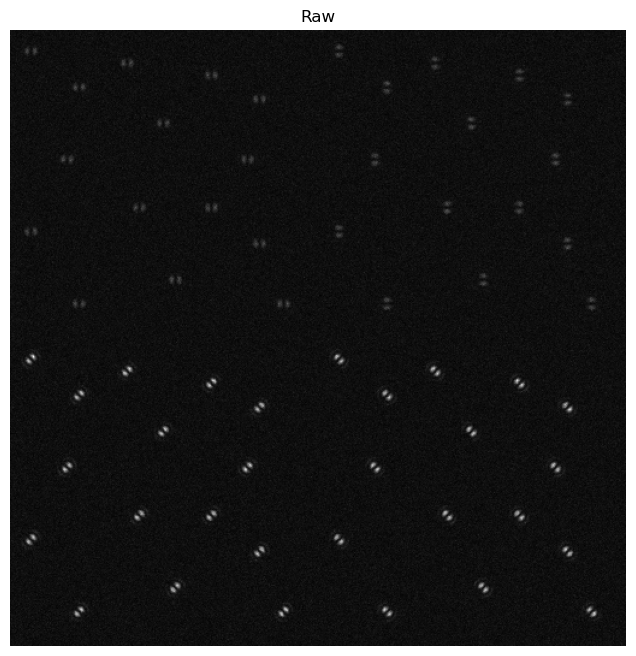

In [3]:
# Setup folders and parameters
dirs = utils.ensure_directories(dir_)
dir0 = dirs['data']
output_dir = dirs['output']
fig_dir = dirs['figs']

# Extract ground-truth params from filename
params_teo = utils.extract_params_from_filename(filename)
delta_teo = params_teo['delta']
rho_teo = params_teo['rho']
eta_teo = params_teo['eta']

#Constants and raw image loading
tif_array=utils.load_simulation_images(dir0+filename)
deltaij = tif_array.shape[1] / 2
num_imgs=10
#tif_array.shape[0]
img_arr = tif_array[1,:,:]

print('Number of images: ' + str(num_imgs))
utils.show_image(img_arr, title='Raw')

### ⚙️ Fitting with Multiple PSF Models (Parallel or Sequential)

This section performs spot fitting for each image using three models:
- `'2Dgaussian'`
- `'1Dgaussian'`
- `'intwindow'`

You can toggle parallel processing using the `parallelflag`.  
Parallel mode leverages all CPU cores using `joblib`, and significantly speeds up batch fitting.

- Fitting results are stored in three separate dictionaries.

This setup is compatible with both interactive and batch (papermill) workflows.


In [4]:
# Parallel fitting section
parallelflag = True
flagplot = False


if parallelflag:
    print('Using parallel processing')
    num_cores = utils.get_cpu_info()
    output_Fit4_2G, output_Fit4_1G, output_Fit4_intWn = utils.run_fitting_parallel(
        tif_array, num_imgs, thresh, min_distance, window_size,num_cores,flagplot)
else:
    print('Using sequential processing')
    output_Fit4_2G, output_Fit4_1G, output_Fit4_intWn = utils.run_fitting_sequential(
        tif_array, num_imgs, thresh, min_distance, window_size, flagplot)


Using parallel processing
Number of CPU cores: 12
Parallel processing


100%|██████████| 10/10 [00:00<00:00, 10027.02it/s]


### 🔄 Registration and Parameter Computation

This section registers the fitting results for each PSF model:
- **1D Gaussian**
- **2D Gaussian**
- **Integration Window**

It uses the `run_registration` function to apply registration to each fitting result and concatenates them.

The registered results are then passed to `compute_dg_parameters` to extract key parameters (`delta`, `rho`, `eta`).

This process is modular and makes the analysis more organized and efficient.


In [5]:
# Set flag for plotting during registration (default: False)
flagplot2=False

# Run registration for each PSF model results using the registration function
Results1G = utils.run_registration(output_Fit4_1G, img_arr, deltaij, threshDist, flagplot2)
Results2G = utils.run_registration(output_Fit4_2G, img_arr, deltaij, threshDist, flagplot2)
ResultsintWn = utils.run_registration(output_Fit4_intWn, img_arr, deltaij, threshDist, flagplot2)

# Compute the fitting parameters (delta, rho, eta) for each PSF model fitting results
delta_all1G, rho_all1G, eta_all1G = utils.compute_dg_parameters(Results1G, K)
delta_all2G, rho_all2G, eta_all2G = utils.compute_dg_parameters(Results2G, K)
delta_allintWn, rho_allintWn, eta_allintWn = utils.compute_dg_parameters(ResultsintWn, K)


### 🖼️ Plotting Identified Spots

This section overlays identified spots on the image for different PSF models (`1Dgaussian`, `2Dgaussian`, `Integrated-Window`):

- **Spot Visualization**: Spots are displayed on the image with unique colors.
- **Plot Saving**: The final figure is saved with a model-specific name.

The plotting logic is handled by the `plotfinalfigure` function in `utils.py`.

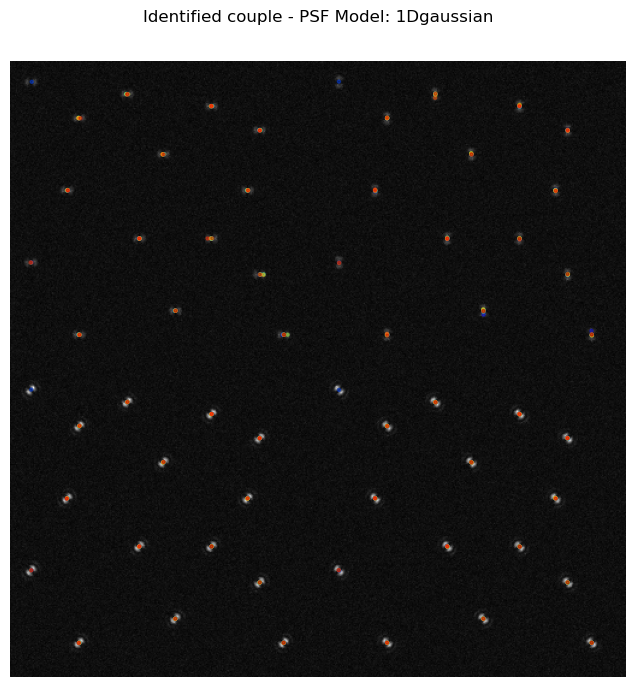

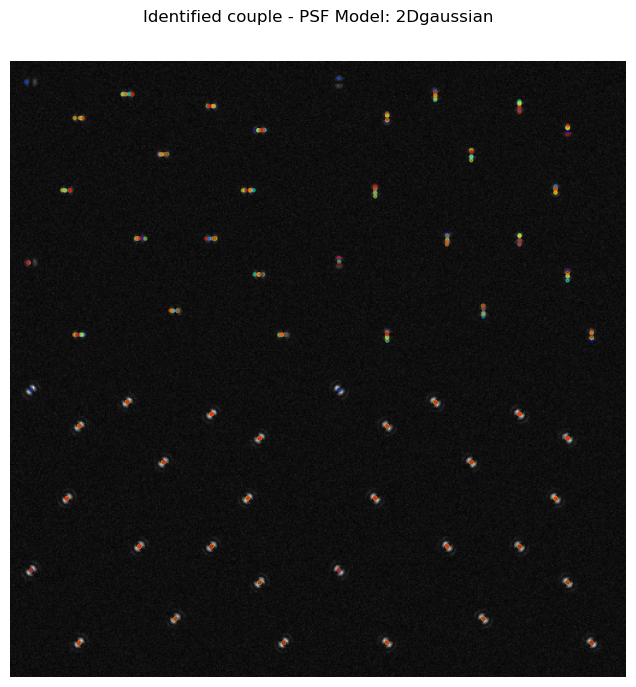

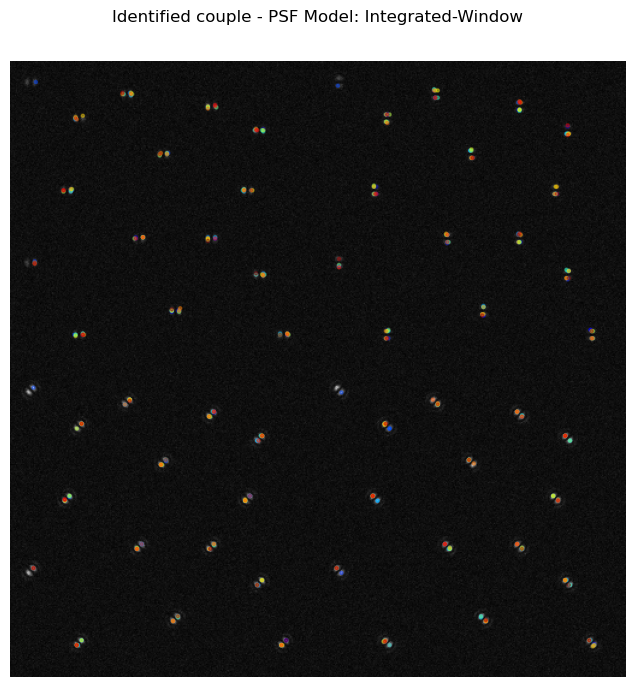

In [6]:
# Plot the identified spots for each PSF model and save the figures

utils.plotfinalfigure(img_arr, Results1G, '1Dgaussian', fig_dir, filename)
utils.plotfinalfigure(img_arr, Results2G, '2Dgaussian', fig_dir, filename)
utils.plotfinalfigure(img_arr, ResultsintWn, 'Integrated-Window', fig_dir, filename)


### 📊 Orientation Recovery Evaluation

This section visualizes the orientation recovery performance for each PSF model (`1Dgaussian`, `2Dgaussian`, and `Integrated-Window`).

- Histograms of the recovered orientation angles(**δ (delta)**, **ρ (rho)** and  **η (eta)**)

- Each subplot shows:
  - Theoretical value (red dashed line)  
  - Mean ± circular standard deviation  
  - RMSE (Root Mean Square Error)

Plots are automatically saved with model-specific filenames.


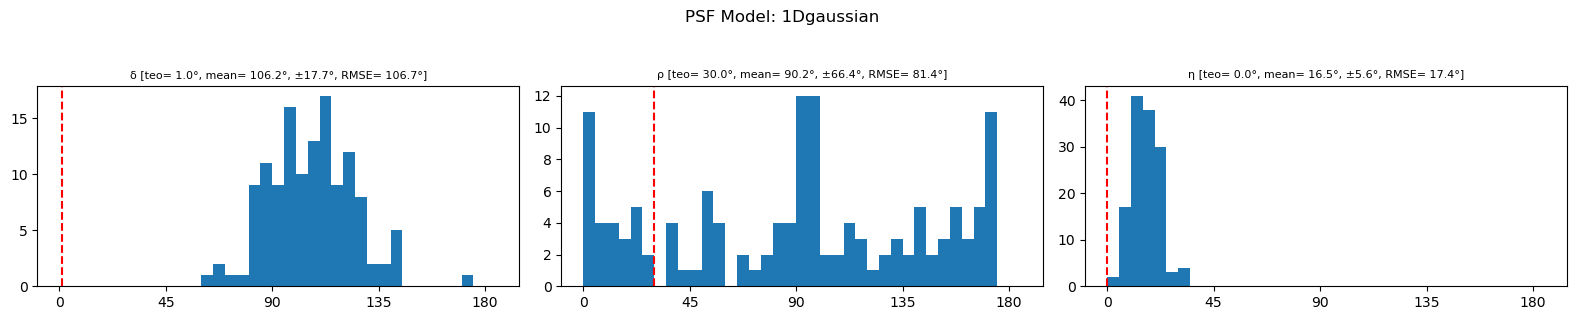

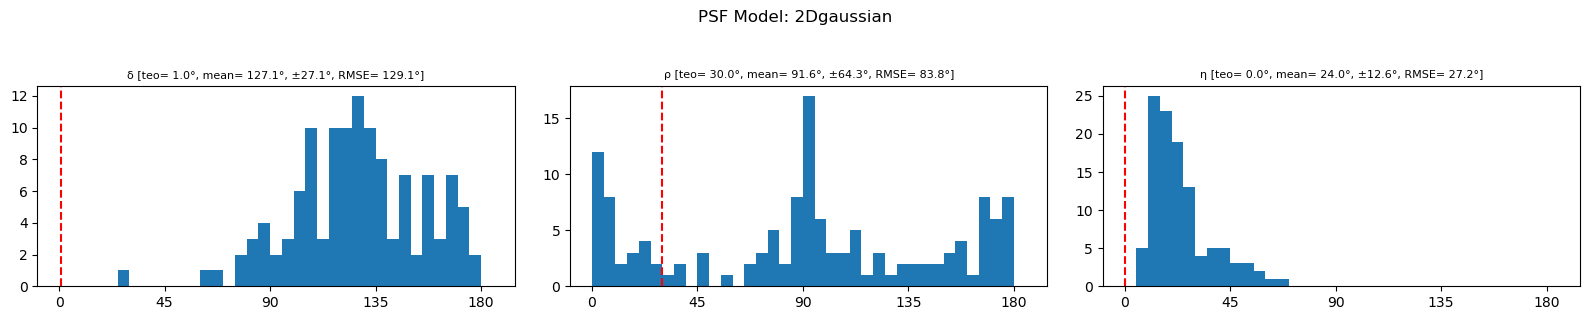

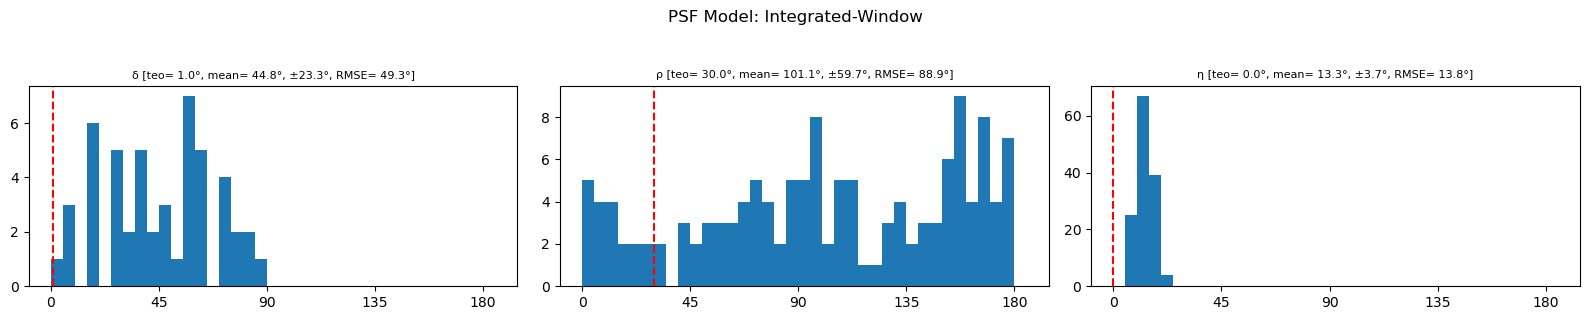

In [7]:
# Evaluate orientation recovery accuracy for each PSF model and save plots
utils.plot_orientation_distributions(
    delta_teo, rho_teo, eta_teo,
    delta_all1G, rho_all1G, eta_all1G,
    '1Dgaussian', fig_dir, filename
)

utils.plot_orientation_distributions(
    delta_teo, rho_teo, eta_teo,
    delta_all2G, rho_all2G, eta_all2G,
    '2Dgaussian', fig_dir, filename
)

utils.plot_orientation_distributions(
    delta_teo, rho_teo, eta_teo,
    delta_allintWn, rho_allintWn, eta_allintWn,
    'Integrated-Window', fig_dir, filename
)


### 💾 Save Fitting Results to `.mat` File

In this step, the processed fitting results from the three PSF models are prepared for export:

- The total intensity of each spot is computed by summing the fitted lobes.
- The orientation parameters (`δ`, `ρ`, and `η`) are appended to each result matrix.
- Metadata and settings (e.g., thresholds, theoretical angles, etc.) are included.
- Everything is saved to a MATLAB-compatible `.mat` file using `scipy.io.savemat`.

This enables downstream analysis in MATLAB or other tools.


In [8]:
# Save fitting results and metadata to .mat file
utils.save_fitting_results_mat(
    Results1G, Results2G, ResultsintWn,
    delta_all1G, rho_all1G, eta_all1G,
    delta_all2G, rho_all2G, eta_all2G,
    delta_allintWn, rho_allintWn, eta_allintWn,
    delta_teo, rho_teo, eta_teo,
    thresh, min_distance, window_size, threshDist,
    filename, output_dir
)

### 📊 Plotting Total Intensity Distribution

In this step, we calculate the total intensity for each PSF model by summing specific columns in the results, and then visualize these total intensities using histograms. The histograms are plotted for each PSF model: 1D Gaussian, 2D Gaussian, and Integrated Window.

The plotting is handled by the `plot_intensity_histograms` function in `utils.py`, which saves the plots as a PNG file.

The intensity values are calculated using the `compute_total_intensity` function from `utils.py`.


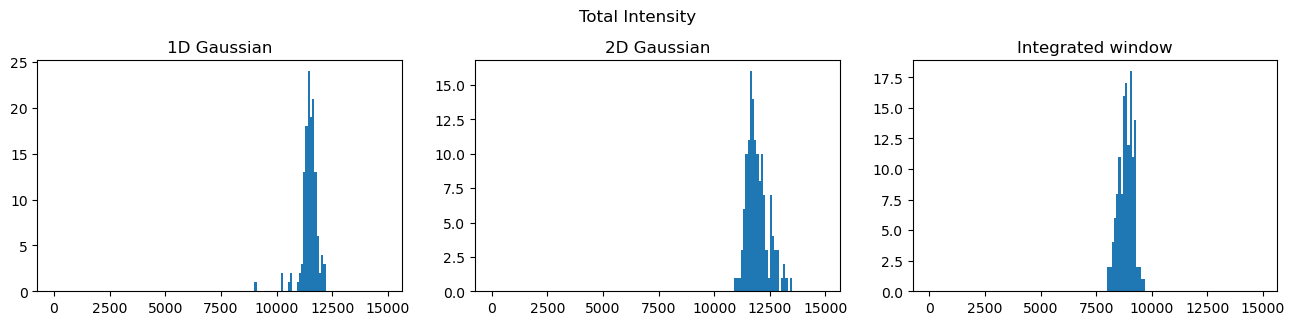

(135,)


In [9]:
# Calculate total intensity for each PSF model using the new function in utils.py
totalInt1G = utils.compute_total_intensity(Results1G)
totalInt2G = utils.compute_total_intensity(Results2G)
totalIntintWn = utils.compute_total_intensity(ResultsintWn)

# Call the plot function from utils.py
utils.plot_intensity_histograms(totalInt1G, totalInt2G, totalIntintWn, fig_dir, filename)

# Print the shape of totalInt1G for confirmation
print(totalInt1G.shape)